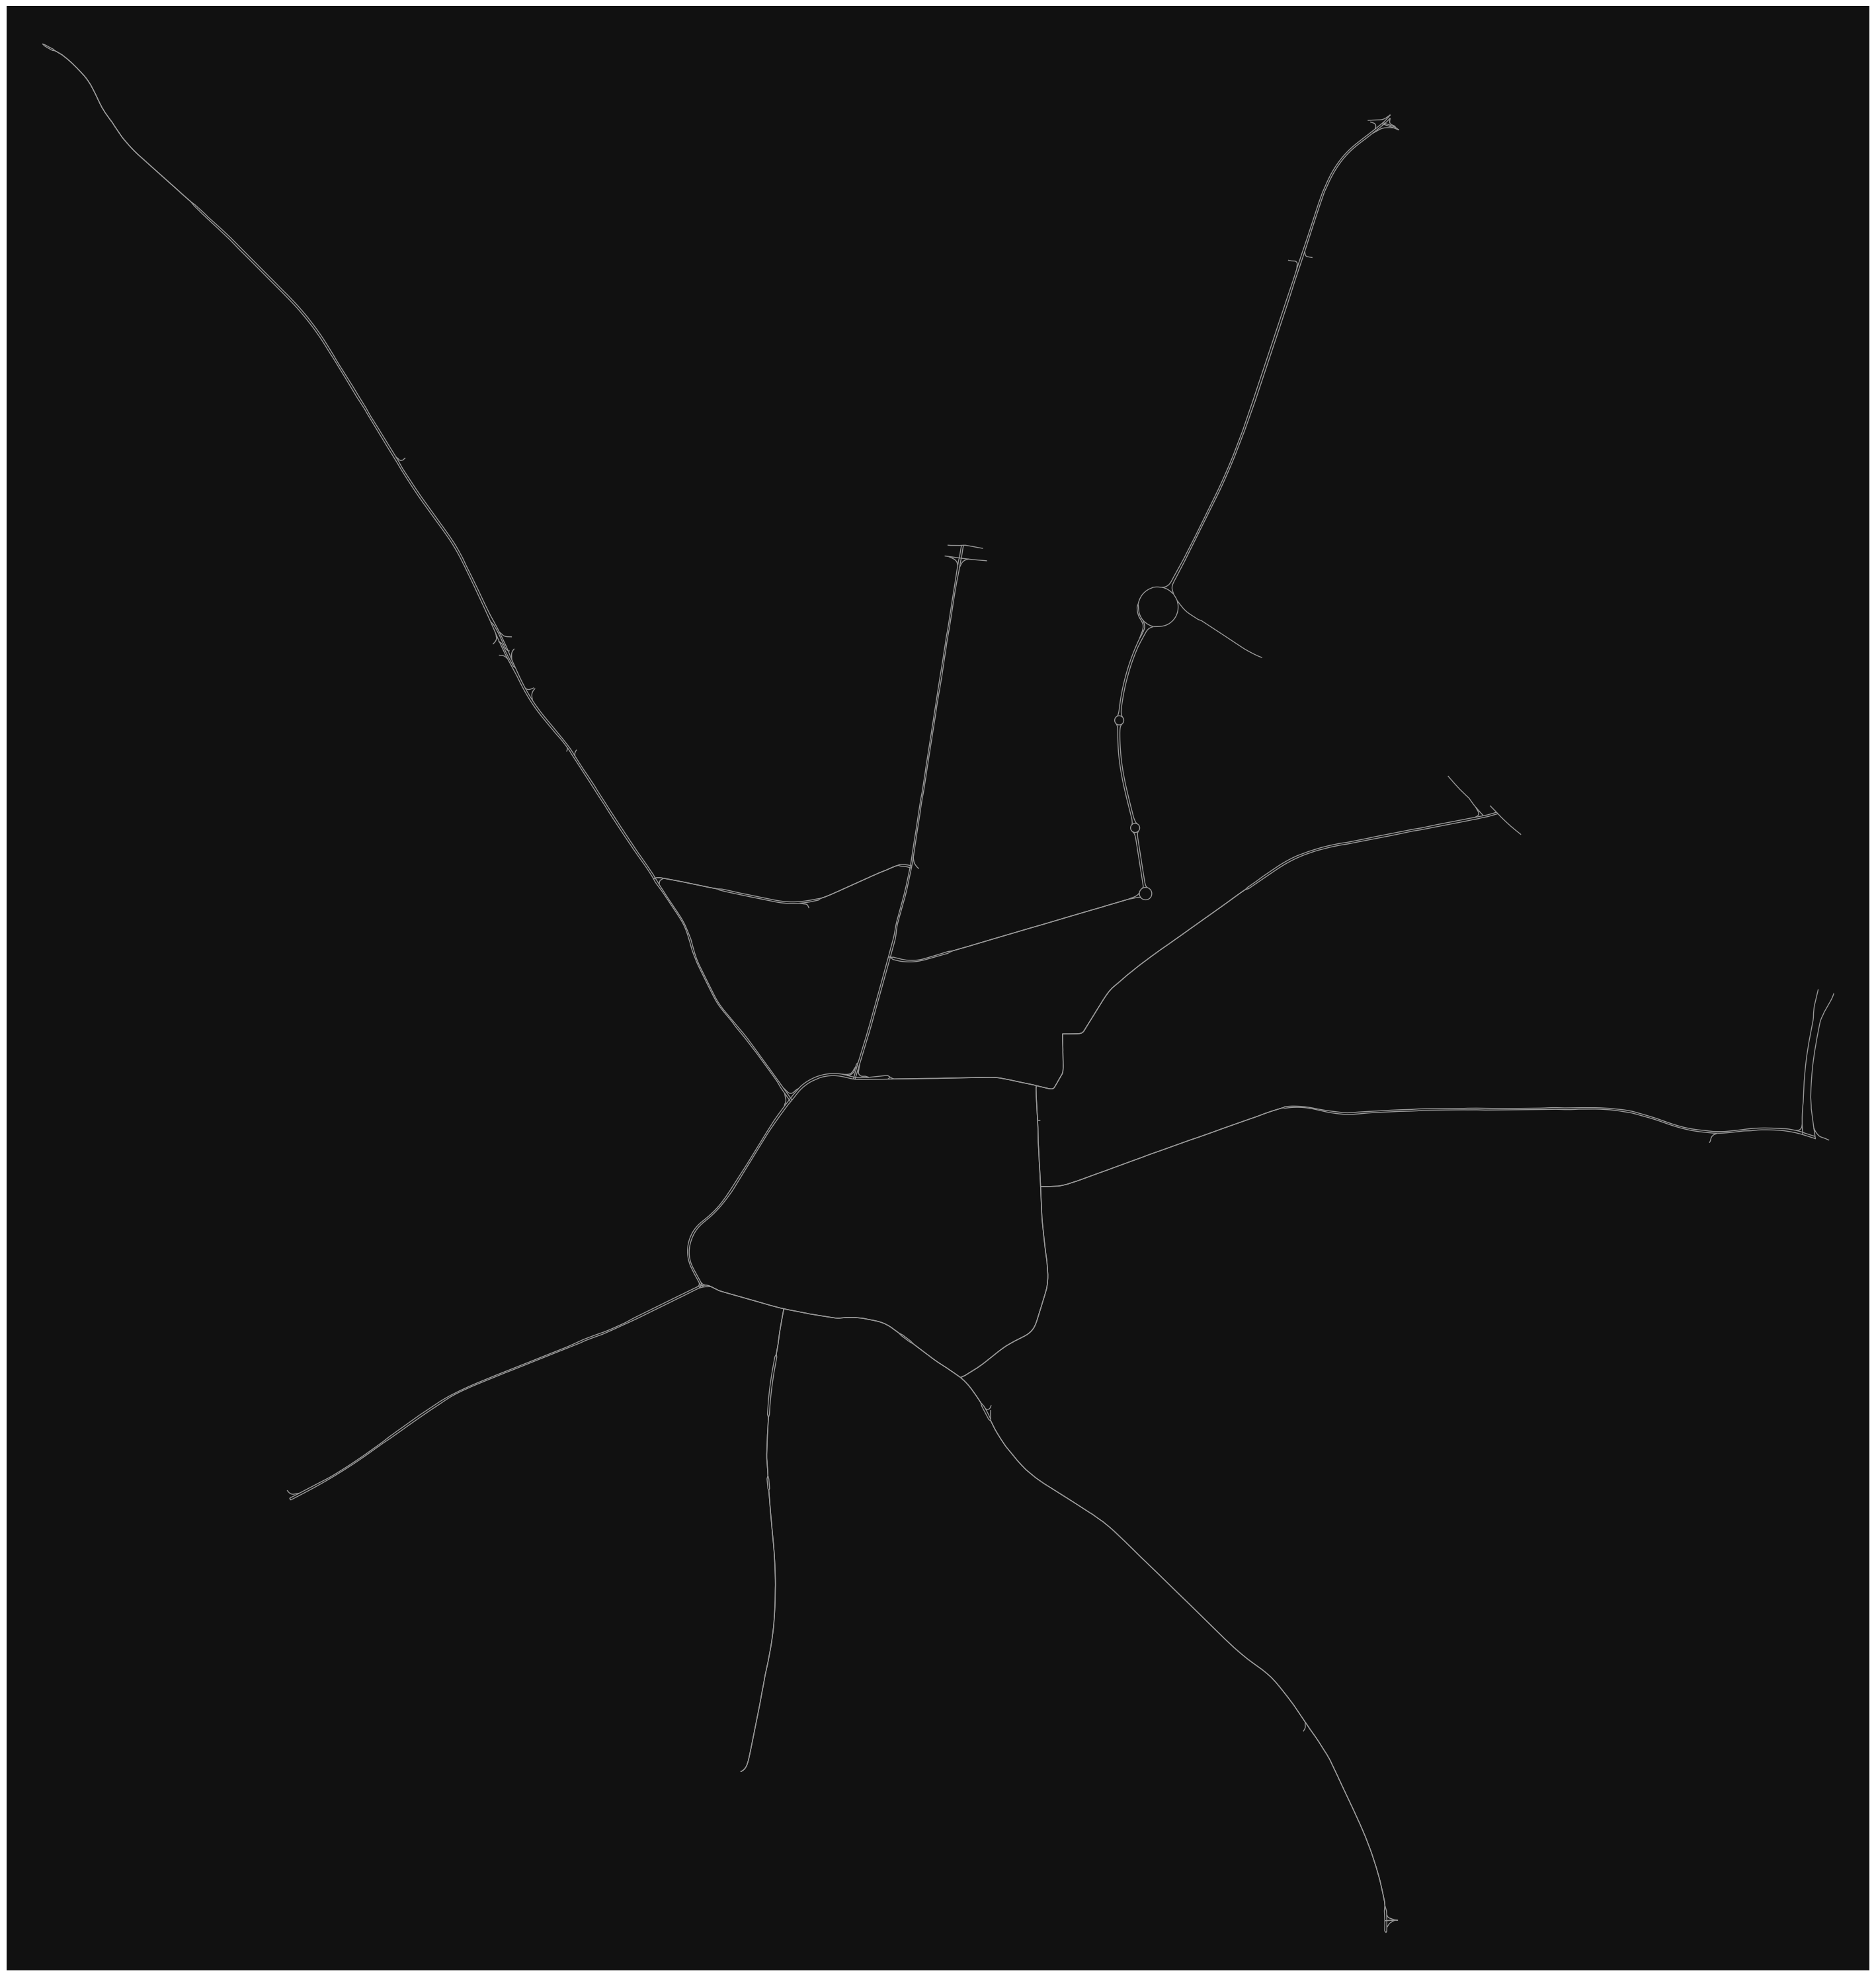

In [75]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline


cf = '["highway"~"primary"]'
G = ox.graph_from_place("Ljubljana, Slovenia", network_type="drive", custom_filter=cf, simplify="False")
fig, ax = ox.plot_graph(G, figsize=(58.33, 38.57), dpi=100, node_size=0)

In [77]:
# seznam osmnid-jev vozlisc
nodes_list = list(G.nodes)
# seznam povezav in atributov lanes, name, maxspeed, length, noter bomo shranili le enosmerne ceste, po tem ko vse dvosmerne spremenimo v dve enosmerni
edges_list = []

# pretvorimo graf G v dva GeoDataFrame-a, enega za vozlisca in enega za povezave
nodes, edges = ox.graph_to_gdfs(G)

# funckcija za računanje povprečne vrednosti v primeru seznama
def average(l):
    if isinstance(l, list):
        lst = []
        for i in l:
            num = int(i)
            lst.append(num)
        if not lst:
            return 0
        return sum(lst) / len(lst)
    # če l ni seznam
    if not isinstance(l, str):
        # za nan vrednosti
        return 0
    return int(l)

# iteriramo čez vse povezave in jih v primeru, da niso enosmerne, spremenimo v dve enosmerni povezavi
for i, row in edges.iterrows():
    attr = row.to_dict()
    u, v = i[0], i[1]
    
    if not attr["oneway"]:
        # dvosmerna cesta
        # število pasov (lanes) je ponekod tabela vrednosti, tam vzamemo povprečje, poleg tega število pasov delimo z 2, ker se štejejo za obe smeri
        # za maxspeed tudi vzamemo povprečje, saj je ponekod več kot ena vrednost
        # atribut artificial dodan, da vem, katere ceste so umetno dodane in niso originalno v edges
        tmp1 = {"u" : u, "v" : v, "osmid" : attr['osmid'], "lanes" : average(attr['lanes']) / 2, "name" : attr['name'], "maxspeed" : average(attr['maxspeed']), "length" : attr['length'], "geometry" : attr['geometry'], "artificial": False}
        edges_list.append(tmp1)
        tmp2 = {"u" : v, "v" : u, "osmid" : attr['osmid'], "lanes" : average(attr['lanes']) / 2, "name" : attr['name'], "maxspeed" : average(attr['maxspeed']), "length" : attr['length'], "geometry" : attr['geometry'], "artificial": True}
        edges_list.append(tmp2)
    else:
        # enosmerna cesta
        # število pasov (lanes) je ponekod tabela vrednosti, tam vzamemo povprečje
        # za maxspeed tudi vzamemo povprečje, saj je ponekod več kot ena vrednost
        tmp = {"u" : u, "v" : v, "osmid" : attr['osmid'], "lanes" : average(attr['lanes']), "name" : attr['name'], "maxspeed" : average(attr['maxspeed']), "length" : attr['length'], "geometry" : attr['geometry'], "artificial": False}
        edges_list.append(tmp)
        
#edges_list

In [78]:
# stehiometrična matrika
import numpy as np
M = np.zeros((len(edges_list), len(nodes_list)), dtype=int)

counter = 0
# -1 v matriki za križišče, kamor vodi cesta, +1 za križišče, od koder cesta prihaja
# reaktanti (vhodne ceste) imajo negativen predznak, produkti (izhodne ceste) pa pozitiven predznak
for e in edges_list:
    izvor = e["u"]
    ponor = e["v"]
    M[counter][nodes_list.index(izvor)] += 1
    M[counter][nodes_list.index(ponor)] -= 1
    counter += 1

# po vrsticah M so metaboliti (ceste), po stolpcih pa reakcije (križišča), kot je običajno
#np.savetxt('test2.txt', M, fmt='%d')

In [79]:
# formula za pretok prometa: flow = speed * density, hitrost je omejitev na tistem odseku ceste,
# gostoto prometa okvirno izračunamo: razdalja med avtomobili 2s, gostota=dolzina_odseka/razdalja_med_avtomobili

for i in edges_list:
    # fiksna hitrost 50 km/h za odseke brez podatka o omejitvi hitrosti (kar pomeni, da je v edges_list maxspeed == 0)
    if i['maxspeed'] == 0:
        i['maxspeed'] = 50
        
    # če je število pasov == 0, to pomeni, da je bilo v originalu NaN, spremenimo na privzeto 1 pas, da ne ustvarimo blokade
    if i['lanes'] == 0:
        i['lanes'] = 1
    
    
    # razdalja med avtomobili je 2s * hitrost[m/s] = razdalja[m] =
    # hitrost[km/h] / 3.6 = hitrost[m/s]
   
    # pretok je bil povsod enak zaradi varnostne razdalje podane v času, kar ni najbolj realistično, zato smo zgoraj umetno znižali varnostno razdaljo
    # pri nižjih hitrostih
    # prilagoditev varnostne razdalje, pri nižjih hitrostih je varnostna razdalja manjša od 1 s
    razdalja_med_avtomobili = (i['maxspeed'] / 3.6) * (2 - ((130 - i['maxspeed']) / 130) / 2)
    
    # gostota prometa je število avtomobilov na izbrano enoto dolžine (1000m) - tj. število avtomobilov na km
    gostota_prometa = 1000/razdalja_med_avtomobili
    # pretok je neodvisen od dolžine odseka 
    # pretok je gostota prometa (v št. avtomobilov / km) * omejitev (v km / h) --> pretok = št. avtomobilov / h
    pretok = gostota_prometa * i['maxspeed']
    
    # tam kjer je več pasov, se pretok ustrezno poveča
    i["maxflow"] = pretok * i["lanes"]


In [142]:
import cobra
from cobra.sampling import sample

jutranja_konica = True
popoldanska_konica = True

# COBRApy model
model = cobra.Model('Ljubljana')

# funkcija za pridobivanje imena metabolita
def ime_metabolita(indeks):
    str = edges_list[indeks]["name"]
    if isinstance(str, list):
        str = "_".join(str)
    try:
        new_str = str.replace(" ", "_")
        return new_str
    except Exception:
        # za NaN vrednosti
        return "NaN"

# dodamo metabolite

# v stohiometrični matriki so po vrsticah ceste (dvosmerne že razdeljene na dve enosmerni), vsaki cesti bo pripadal en metabolit
# dodamo še po en metabolit za vsako križišče (dodatnih len(nodes_list) metabolitov)
for idx in range(len(edges_list) + len(nodes_list)):
    if idx < len(edges_list):
        ime = ime_metabolita(idx)
        metabolite = cobra.Metabolite(id=f'M{idx}-{ime}', name=f'Metabolite{idx}-{ime}', compartment='c')
    else:
        metabolite = cobra.Metabolite(id=f'M{idx}-intersection{nodes_list[idx-len(edges_list)]}', name=f'Metabolite{idx}-krizisce{nodes_list[idx-len(edges_list)]}', compartment='c')
    model.add_metabolites([metabolite])

# dodamo reakcije 
# reakcij bo toliko kot je vsota izhodnih in vhodnih cest v križiščih
stevilo_reakcij = 0
for idx in range(len(M[0])):  
    # dodamo reakcije metabolitov/cest, ki sodelujejo v tem križišču, vhodne ceste bodo metabolit št. (indeks -1 v matriki M)*2 - ker so cesta_in sodi metaboliti,
    # izhodne ceste bodo cesta_out - metabolit št. (indeks +1 v matriki M)*2 + 1, ker so cesta_out lihi metaboliti 

    # poiščemo +1 in -1 v pravem stolpcu stehiometrične matrike
    counter = 0
    counter_metabolitov_krizisc = len(edges_list) + idx
    vhodne_ceste = []
    izhodne_ceste = []
    vhodne_ceste_maxflow = []
    izhodne_ceste_maxflow = []
                 
    # najprej preverimo, če je slučajno to uptake ali secrete reakcija
    for el in M[:, idx]:
        if el == 1:
            indeks_metabolita = counter
            izhodne_ceste.append(indeks_metabolita)
            izhodne_ceste_maxflow.append(edges_list[indeks_metabolita]['maxflow'])
        elif el == -1:
            indeks_metabolita = counter
            vhodne_ceste.append(indeks_metabolita)
            vhodne_ceste_maxflow.append(edges_list[indeks_metabolita]['maxflow'])
        counter += 1
    
    # uptake reakcije
    if jutranja_konica and len(vhodne_ceste) == 0:
       for element in izhodne_ceste:
            reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-uptake', name=f'Reaction{stevilo_reakcij}-uptake')
            stevilo_reakcij += 1
            indeks_metabolita = element
            ime = ime_metabolita(indeks_metabolita)
            
            metabolit1 = cobra.Metabolite(f'M{indeks_metabolita}-{ime}')
            reakcija.add_metabolites({metabolit1: 1.0})
            reakcija.upper_bound = izhodne_ceste_maxflow[izhodne_ceste.index(element)]
            reakcija.lower_bound = 1660.0
            model.add_reactions([reakcija]) 
                 
    # secrete reakcije
    elif popoldanska_konica and len(izhodne_ceste) == 0:
        for element in vhodne_ceste:
            reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}-secrete', name=f'Reaction{stevilo_reakcij}-secrete')
            stevilo_reakcij += 1
            indeks_metabolita = element
            ime = ime_metabolita(indeks_metabolita)
            
            metabolit1 = cobra.Metabolite(f'M{indeks_metabolita}-{ime}')
            reakcija.add_metabolites({metabolit1: -1.0})
            reakcija.upper_bound = vhodne_ceste_maxflow[vhodne_ceste.index(element)]
            model.add_reactions([reakcija])
    
    # križišči M324 ter M390 imata koordinate (14.5060117, 46.0575901) ter (14.5060532 46.0576844) - to je križišče med Dunajsko, Tivolsko, Slovensko
    # ter Trgom osvobodilne fronte - dodamo dodatni umetni reakciji, ki vključujeta ti dve križišči
    else:
        counter = 0
        for el in M[:, idx]:
            if el != 0:
                reakcija = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
                stevilo_reakcij += 1
                indeks_metabolita = counter
                ime = ime_metabolita(indeks_metabolita)
                if el == 1:
                    
                    metabolit1 = cobra.Metabolite(f'M{indeks_metabolita}-{ime}')
                    reakcija.add_metabolites({metabolit1: 1.0})

                    metabolit2 = cobra.Metabolite(f'M{counter_metabolitov_krizisc}-intersection')
                    reakcija.add_metabolites({metabolit2: -1.0})

                    reakcija.upper_bound = edges_list[indeks_metabolita]['maxflow']
                elif el == -1:
                    metabolit1 = cobra.Metabolite(f'M{indeks_metabolita}-{ime}')
                    reakcija.add_metabolites({metabolit1: -1.0})

                    metabolit2 = cobra.Metabolite(f'M{counter_metabolitov_krizisc}-intersection')
                    reakcija.add_metabolites({metabolit2: 1.0})

                    reakcija.upper_bound = edges_list[indeks_metabolita]['maxflow']
                model.add_reactions([reakcija])
                #print("podatki o križišču št.", counter_metabolitov_krizisc, ":", nodes.iloc[idx]["x"], nodes.iloc[idx]["y"])
            counter += 1
        
if jutranja_konica:
    # dodamo umetno reakcijo: križišče v centru --> 0
    reakcija1 = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
    stevilo_reakcij += 1
    metabolit1 = cobra.Metabolite(f'M324-intersection')
    reakcija1.add_metabolites({metabolit1: -1.0})
    reakcija1.lower_bound = 1000.0
    reakcija1.upper_bound = 8000.0
    model.add_reactions([reakcija1])

    reakcija2 = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
    stevilo_reakcij += 1
    metabolit2 = cobra.Metabolite(f'M390-intersection')
    reakcija2.add_metabolites({metabolit2: -1.0})
    reakcija2.lower_bound = 1000.0
    reakcija2.upper_bound = 8000.0
    model.add_reactions([reakcija2])

'''elif popoldanska_konica:
    # dodamo umetno rekacijo: 0 --> križišče v centru
    reakcija1 = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
    stevilo_reakcij += 1
    metabolit1 = cobra.Metabolite(f'M324-intersection')
    reakcija1.add_metabolites({metabolit1: 1.0})
    reakcija1.upper_bound = 10000.0
    model.add_reactions([reakcija1])

    reakcija2 = cobra.Reaction(id=f'R{stevilo_reakcij}', name=f'Reaction{stevilo_reakcij}')
    stevilo_reakcij += 1
    metabolit2 = cobra.Metabolite(f'M390-intersection')
    reakcija2.add_metabolites({metabolit2: 1.0})
    reakcija2.upper_bound = 10000.0
    model.add_reactions([reakcija2])'''
        

    
#for reaction in model.reactions:
#    print(reaction, reaction.lower_bound, reaction.upper_bound)
obj1 = model.reactions.get_by_id('R646')
obj2 = model.reactions.get_by_id('R647')
model.objective = {obj1: 1.0, obj2: 1.0}
solution = model.optimize()

print(solution)

#model.summary()

#for reaction in model.reactions:
#    print(reaction, solution.fluxes[reaction.id])

#s = sample(model, 1000)
#s.head()


<Solution 8509.091 at 0x1f63a1b74c0>


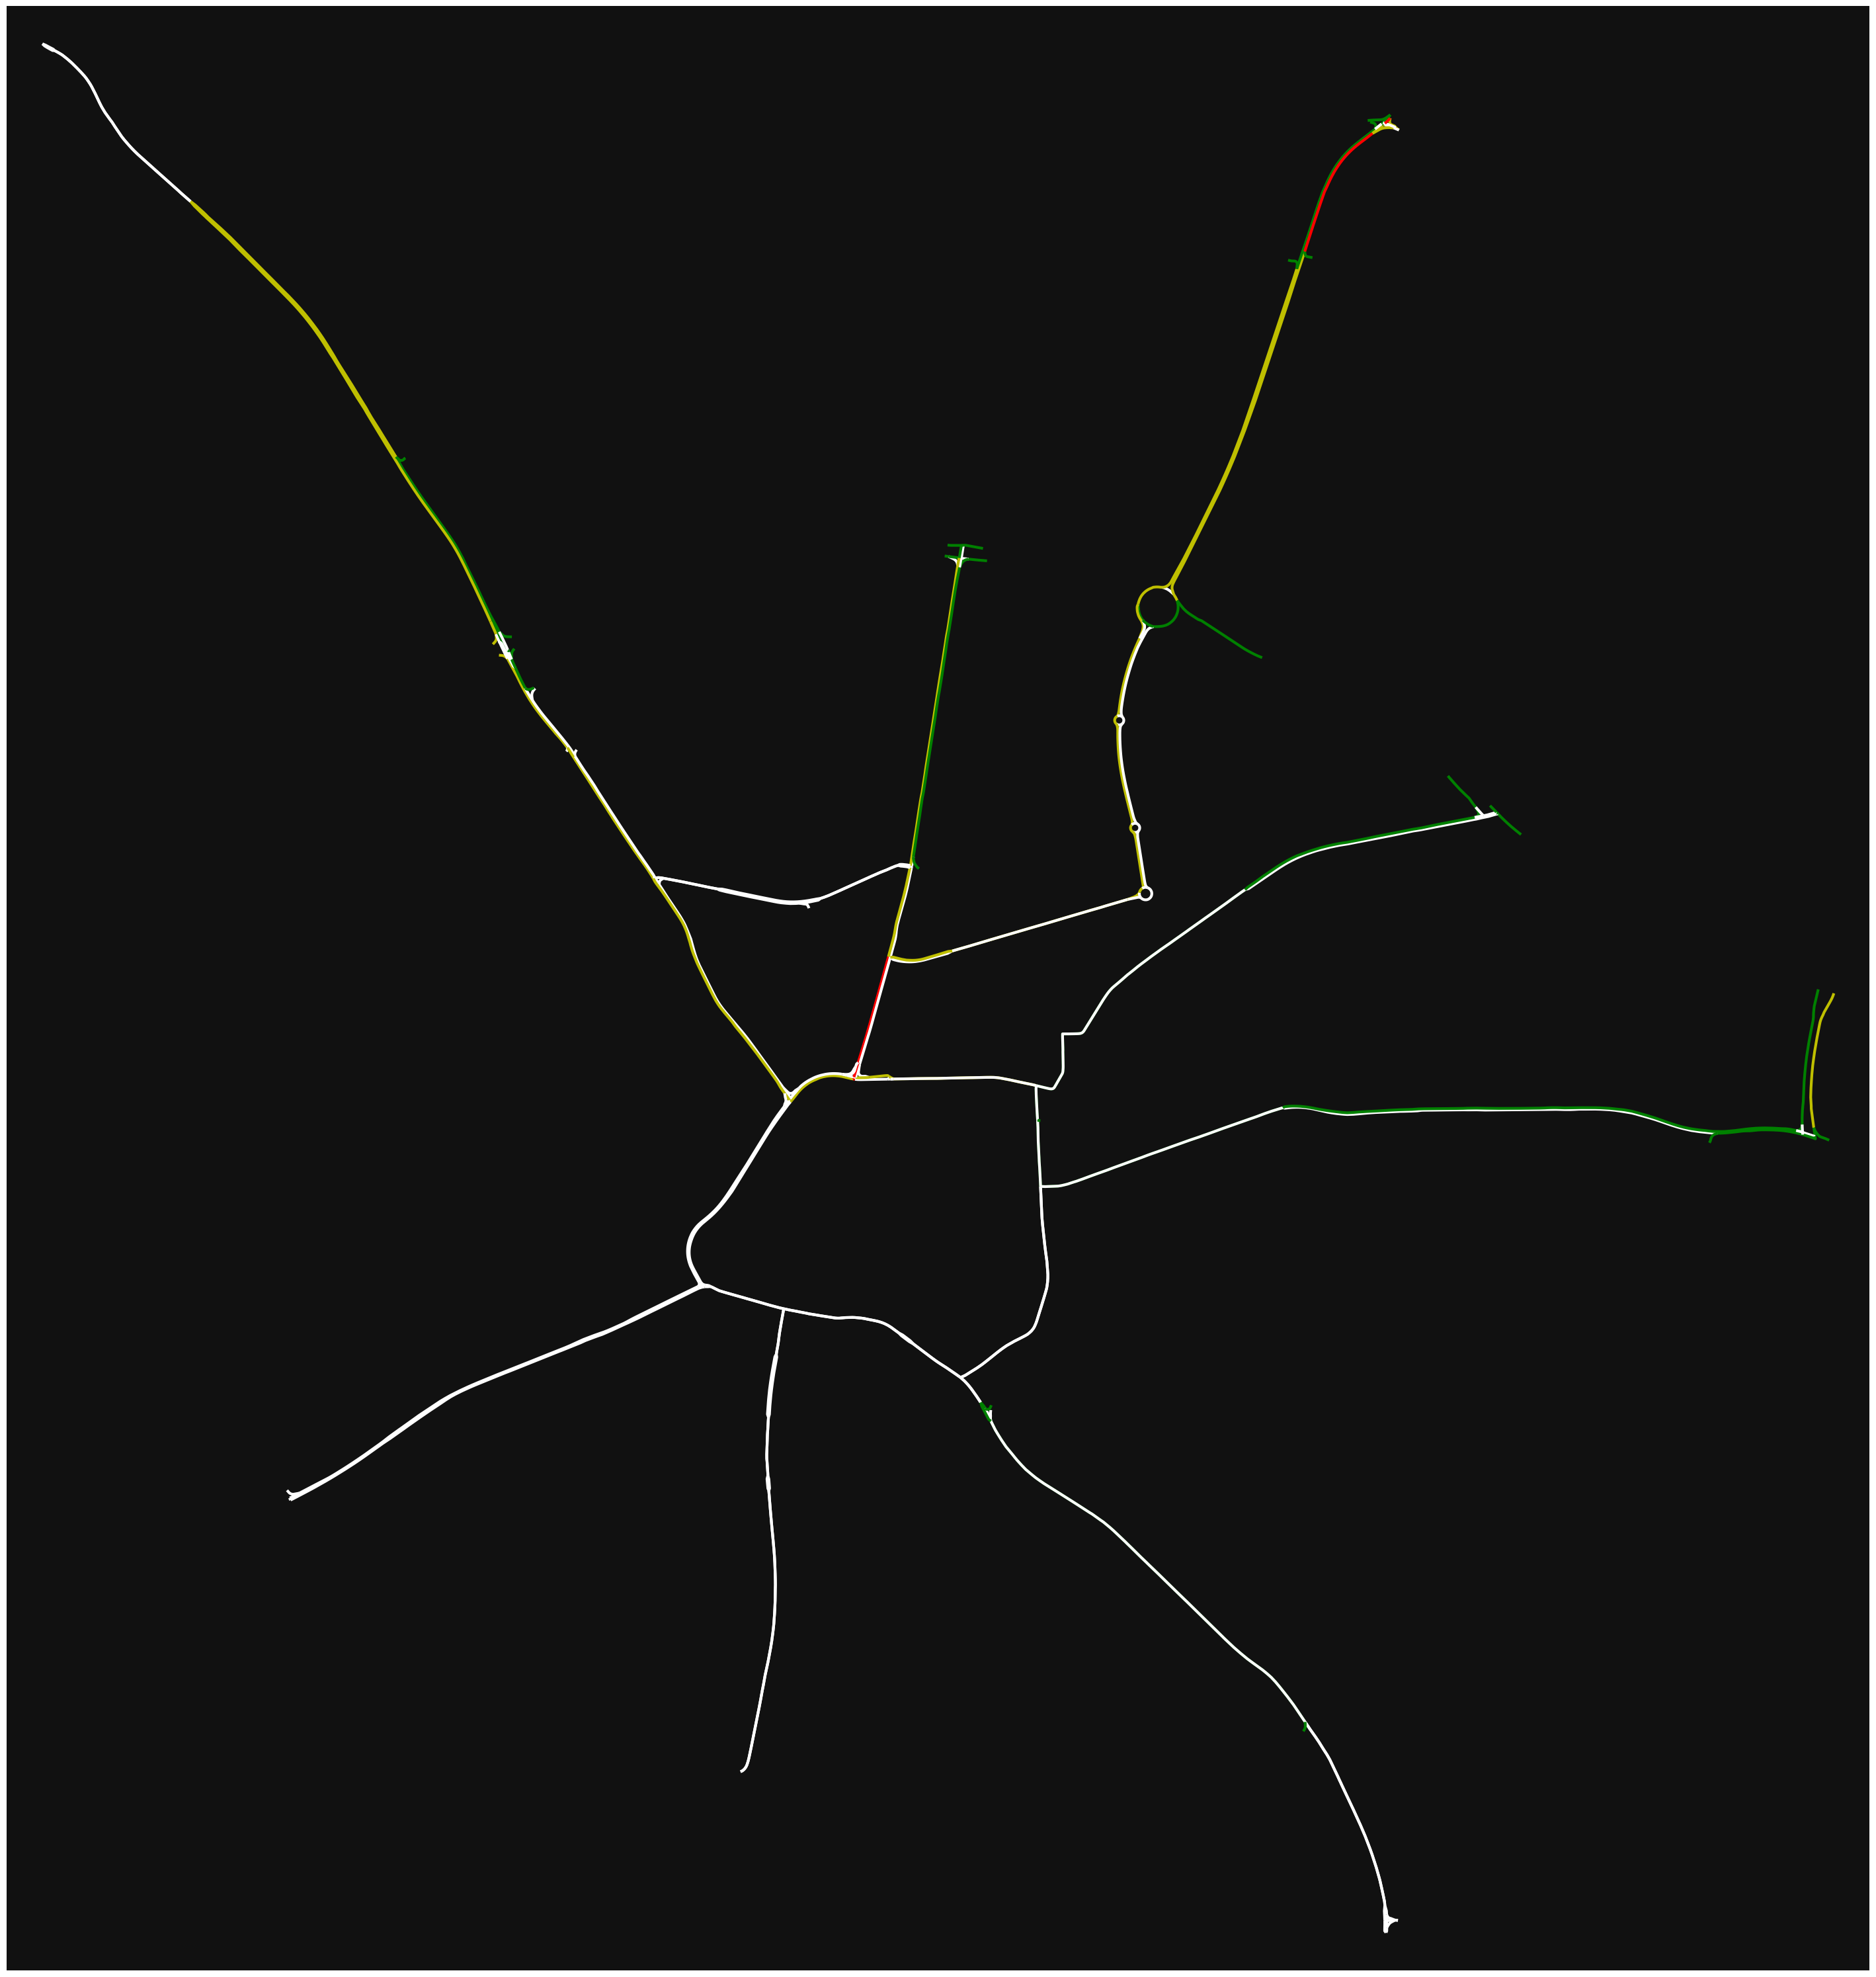

In [158]:
# analiziramo pretoke po cestah in jih shranimo v tabelo, tam kjer so umetno ločene dvosmerne ceste (v edges_list je artificial = True), bomo naredili
# vsoto pretoka v obeh smereh
edges_fluxes = [0] * len(G.edges)
# ker so reakcije oblike: Mx-intersection -> Mz, Mz -> My-intersection, moramo voditi evidenco, da ne bomo pretoka dodajali 2x
ze_dodano = [False] * len(G.edges)
ze_dodano_artificial = [False] * len(G.edges)
for reaction in model.reactions:
    # indeks metabolitov, ki niso intersection, je položaj ceste v edges_list
    try:
        r1 = reaction.reactants[0].id.split('-')[0].split('M')[1] 
        r1 = int(r1)
    except Exception:
        r1 = -1
    
    try:
        p1 = reaction.products[0].id.split('-')[0].split('M')[1]
        p1 = int(p1)
    except Exception:
        p1 = -1
    
    if r1 >= 0 and r1 < len(edges_list):
        target_osmid_list = edges_list[r1]['osmid']
        mask = edges['osmid'].apply(lambda osmids: osmids == target_osmid_list)
        indeks = list(mask).index(True)
        # dvosmerna cesta
        if not ze_dodano_artificial[indeks] and edges_list[r1]['artificial']:
            edges_fluxes[indeks] += solution.fluxes[reaction.id]
            ze_dodano_artificial[indeks] = True
        else:
            if not ze_dodano[indeks]:
                edges_fluxes[indeks] = solution.fluxes[reaction.id]
                ze_dodano[indeks] = True
    elif p1 >= 0 and p1 < len(edges_list):
        target_osmid_list = edges_list[p1]['osmid']
        mask = edges['osmid'].apply(lambda osmids: osmids == target_osmid_list)
        indeks = list(mask).index(True)
        # dvosmerna cesta
        if not ze_dodano_artificial[indeks] and edges_list[p1]['artificial']:
            edges_fluxes[indeks] += solution.fluxes[reaction.id]
            ze_dodano_artificial[indeks] = True
        else:
            if not ze_dodano[indeks]:
                edges_fluxes[indeks] = solution.fluxes[reaction.id]
                ze_dodano[indeks] = True
        

barve = ['']*len(G.edges)
for i in range(len(G.edges)):
    if edges_fluxes[i] < 200:
        barve[i] = 'w'
    elif edges_fluxes[i] >= 200 and edges_fluxes[i] <= 2000:
        barve[i] = 'g'
    elif edges_fluxes[i] > 2000 and edges_fluxes[i] < 3500:
        barve[i] = 'y'
    else:
        barve[i] = 'r'

fig, ax = ox.plot_graph(G, figsize=(58.33, 38.57), dpi=100, node_size=0, edge_color=barve, edge_linewidth=3)
    
    

In [99]:
for el in edges_list:
 el['geometry'] = list(el['geometry'].coords)

In [15]:
# za računanje povprečja koordinat
def average_coord(lst):
    x_coord = 0
    y_coord = 0
    for el in lst:
        x_coord += el[0]
        y_coord += el[1]
    x_coord /= len(lst)
    y_coord /= len(lst)
    return (x_coord, y_coord)

for el in edges_list:
    av = average_coord(el['geometry'])
    el['av_coord'] = av